# Importando paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# Leyendo el archivo

In [3]:
df = pd.read_pickle('EasyMoney_1_isa.pkl', compression='zip')

In [4]:
df.head() # comprobando que lo ha leído bien

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,region_name,salary_categ,dif_loans,dif_mortgage,dif_funds,dif_securities,dif_long_term_deposit,dif_em_account_pp,dif_credit_card,dif_payroll,dif_pension_plan,dif_payroll_account,dif_emc_account,dif_debit_card,dif_em_account_p,dif_em_acount,dif_short_term_deposit,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,cuenta,ahorro_inversion,financiacion
0,15891,2018-07-28,2018-07-28,KAT,1,desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,28.0,H,59,0,-999.0,Madrid,Desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0.0,1,0,0,0
1,15891,2018-08-28,2018-07-28,KAT,0,particulares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,59,0,-999.0,Madrid,Desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1.000000,0,0,0.0,1,-1,0,0
2,16063,2018-11-28,2018-11-19,KAT,1,desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,62,0,-999.0,Madrid,Desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.290323,1,0,0.0,0,0,0,0
3,16063,2018-12-28,2018-11-19,KAT,1,particulares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,62,0,-999.0,Madrid,Desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.258065,0,0,0.0,0,0,0,0
4,16063,2019-01-28,2018-11-19,KAT,1,particulares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,62,0,-999.0,Madrid,Desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.258065,0,0,0.0,0,0,0,0


Dado que queremos predecir las altas del mes de junio, vamos a tener que tomar como variables las del mes inmediatamente anterior. Es decir, para predecir junio usaremos las variables de ese cliente del mes de mayo.

In [5]:
vars_colums=['pk_cid','pk_partition',
'entry_date',             
'entry_channel',                 
'active_customer',              
'segment',                     
'country_id',                  
'region_code',                  
'gender',                         
'age',                            
'deceased',              
'salary', 
'credit_card', 
'meses_alta',                   
'new_client',                    
'productos_totales',
'ingresos_producto',
'cliente_activo']

In [6]:
delta_productos_easymoney=['dif_credit_card']

In [7]:
df_altas=df.melt(id_vars=vars_colums,
            value_vars=delta_productos_easymoney,
            var_name='Product',
            value_name='Count')

In [8]:
df_altas.isnull().sum()

pk_cid               0
pk_partition         0
entry_date           0
entry_channel        0
active_customer      0
segment              0
country_id           0
region_code          0
gender               0
age                  0
deceased             0
salary               0
credit_card          0
meses_alta           0
new_client           0
productos_totales    0
ingresos_producto    0
cliente_activo       0
Product              0
Count                0
dtype: int64

# Producto cartesiano

In [9]:
lista_fechas=['2018-01-28',
'2018-02-28',
'2018-03-28',
'2018-04-28',
'2018-05-28',
'2018-06-28',
'2018-07-28',
'2018-08-28',
'2018-09-28',
'2018-10-28',
'2018-11-28',
'2018-12-28',
'2019-01-28',
'2019-02-28',
'2019-03-28',
'2019-04-28',
'2019-05-28',             
'2019-06-28'] # incluyendo el mes que queremos predecir

In [10]:
# Queremos usar solo clientes activos el ultimo mes:
lista_clientes=df_altas[(df_altas['cliente_activo']==1) & 
                        (df_altas['pk_partition']=='2019-05-28')]["pk_cid"].unique().tolist()



In [11]:
len(lista_clientes)

344704

Tenemos un total de 344 mil registros de clientes (uno por cliente, no repetidos). Ahora bien, no tenemos exactamente los mismos clientes para todos los meses para em_acount, por lo que hay que simularlo usando el producto cartesiano. La idea es "simular" tener datos de todos los clientes para todas las fechas, asegurando así que tengamos una representación completa de todas las posibles combinaciones de clientes y fechas, incluso si en realidad no es así. Por eso, queremos que en nuestro nuevo dataset haya un total de 344mil registros para cada fecha.

In [12]:
lista_productos=['dif_credit_card']

In [13]:
cartesian_product = pd.MultiIndex.from_product([lista_fechas, 
                                                lista_clientes , 
                                                lista_productos], names = ["pk_partition", "pk_cid", "Product"])
len(cartesian_product)

6204672

In [14]:
cartesian_product

MultiIndex([('2018-01-28',   16203, 'dif_credit_card'),
            ('2018-01-28',   16502, 'dif_credit_card'),
            ('2018-01-28',   17457, 'dif_credit_card'),
            ('2018-01-28',   17799, 'dif_credit_card'),
            ('2018-01-28',   17970, 'dif_credit_card'),
            ('2018-01-28',   17980, 'dif_credit_card'),
            ('2018-01-28',   18146, 'dif_credit_card'),
            ('2018-01-28',   18704, 'dif_credit_card'),
            ('2018-01-28',   19021, 'dif_credit_card'),
            ('2018-01-28',   19268, 'dif_credit_card'),
            ...
            ('2019-06-28', 1553390, 'dif_credit_card'),
            ('2019-06-28', 1553393, 'dif_credit_card'),
            ('2019-06-28', 1553415, 'dif_credit_card'),
            ('2019-06-28', 1553429, 'dif_credit_card'),
            ('2019-06-28', 1553436, 'dif_credit_card'),
            ('2019-06-28', 1553456, 'dif_credit_card'),
            ('2019-06-28', 1553541, 'dif_credit_card'),
            ('2019-06-28', 15535

In [15]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df.tail()

,pk_partition,pk_cid,Product
6204667,2019-06-28,1553456,dif_credit_card
6204668,2019-06-28,1553541,dif_credit_card
6204669,2019-06-28,1553559,dif_credit_card
6204670,2019-06-28,1553565,dif_credit_card
6204671,2019-06-28,1553571,dif_credit_card


In [16]:
# formateamos la variable pk_partition como fecha
full_df['pk_partition']=pd.to_datetime(full_df['pk_partition'], format='%Y-%m-%d')

In [17]:
full_df.groupby('pk_partition')['pk_cid'].size()
#efectivamente, lo hemos hecho bien

pk_partition
2018-01-28    344704
2018-02-28    344704
2018-03-28    344704
2018-04-28    344704
2018-05-28    344704
2018-06-28    344704
2018-07-28    344704
2018-08-28    344704
2018-09-28    344704
2018-10-28    344704
2018-11-28    344704
2018-12-28    344704
2019-01-28    344704
2019-02-28    344704
2019-03-28    344704
2019-04-28    344704
2019-05-28    344704
2019-06-28    344704
Name: pk_cid, dtype: int64

In [18]:
full_df = pd.merge(full_df, df_altas, on = ["pk_partition", "pk_cid", "Product"], how = 'left')

In [19]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    344704
2018-02-28    344704
2018-03-28    344704
2018-04-28    344704
2018-05-28    344704
2018-06-28    344704
2018-07-28    344704
2018-08-28    344704
2018-09-28    344704
2018-10-28    344704
2018-11-28    344704
2018-12-28    344704
2019-01-28    344704
2019-02-28    344704
2019-03-28    344704
2019-04-28    344704
2019-05-28    344704
2019-06-28    344704
Name: pk_cid, dtype: int64

In [20]:
del df_altas

In [21]:
del df

In [22]:
full_df.isna().sum() # al crearse tantas entradas ficticias, cuando hacemos el merge se nos generan nulos

pk_partition               0
pk_cid                     0
Product                    0
entry_date           1259563
entry_channel        1259563
active_customer      1259563
segment              1259563
country_id           1259563
region_code          1259563
gender               1259563
age                  1259563
deceased             1259563
salary               1259563
credit_card          1259563
meses_alta           1259563
new_client           1259563
productos_totales    1259563
ingresos_producto    1259563
cliente_activo       1259563
Count                1259563
dtype: int64

In [23]:
full_df.shape #hay aproximadamente 1/6 de nulos

(6204672, 20)

In [24]:
full_df.drop (full_df[ (full_df['pk_partition']!='2019-06-28') &
                    (full_df['entry_date'].isnull()) ].index, axis=0, inplace=True)

In [25]:
# Comprobamos el borrado:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    233491
2018-02-28    236751
2018-03-28    239374
2018-04-28    241487
2018-05-28    243824
2018-06-28    245905
2018-07-28    265666
2018-08-28    277576
2018-09-28    296059
2018-10-28    314142
2018-11-28    324099
2018-12-28    328275
2019-01-28    333082
2019-02-28    337077
2019-03-28    340520
2019-04-28    343077
2019-05-28    344704
2019-06-28    344704
Name: pk_cid, dtype: int64

In [26]:
full_df.shape #tiene sentido, dado que hemos quitado 1 millón -> 5millones restantes

(5289813, 20)

In [27]:
full_df.head()

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,credit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count
2,2018-01-28,17457,dif_credit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0
3,2018-01-28,17799,dif_credit_card,2018-01-04,KAT,1.0,particulares,ES,28.0,H,46.0,0.0,84511.86,0.0,0.774194,1.0,1.0,10.0,1.0,0.0
4,2018-01-28,17970,dif_credit_card,2015-04-16,KAT,1.0,particulares,ES,28.0,V,75.0,0.0,-999.00,0.0,32.838710,0.0,4.0,0.0,1.0,0.0
7,2018-01-28,18704,dif_credit_card,2017-01-20,KAT,1.0,particulares,ES,41.0,H,55.0,0.0,75187.44,0.0,12.032258,0.0,1.0,0.0,1.0,0.0
8,2018-01-28,19021,dif_credit_card,2016-10-11,KAT,1.0,particulares,ES,28.0,V,63.0,0.0,129492.36,1.0,15.290323,0.0,1.0,0.0,1.0,0.0


In [28]:
full_df.drop(full_df[(full_df['new_client']==0) &
                        (full_df['cliente_activo']==0) & 
                       (full_df['credit_card']==0) &
                       (full_df['Count']==0) ].index ,axis=0, inplace=True)

In [29]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    233491
2018-02-28    236751
2018-03-28    239374
2018-04-28    241487
2018-05-28    243824
2018-06-28    245905
2018-07-28    265666
2018-08-28    277576
2018-09-28    296059
2018-10-28    314142
2018-11-28    324099
2018-12-28    328275
2019-01-28    333082
2019-02-28    337077
2019-03-28    340520
2019-04-28    343077
2019-05-28    344704
2019-06-28    344704
Name: pk_cid, dtype: int64

In [30]:
full_df[(full_df['pk_cid']==1231342)]

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,credit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count
152627,2018-01-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,13.258065,0.0,1.0,0.0,1.0,0.0
497331,2018-02-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,14.258065,0.0,1.0,0.0,1.0,0.0
842035,2018-03-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,15.161290,0.0,1.0,0.0,1.0,0.0
1186739,2018-04-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,16.161290,0.0,1.0,0.0,1.0,0.0
1531443,2018-05-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,17.129032,0.0,1.0,0.0,1.0,0.0
1876147,2018-06-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,18.129032,0.0,1.0,0.0,1.0,0.0
2220851,2018-07-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,19.096774,0.0,0.0,0.0,1.0,0.0
2565555,2018-08-28,1231342,dif_credit_card,2016-12-13,KHE,0.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,20.096774,0.0,0.0,0.0,1.0,0.0
2910259,2018-09-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,21.096774,0.0,1.0,10.0,1.0,0.0
3254963,2018-10-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,21.0,0.0,72759.93,0.0,22.064516,0.0,1.0,0.0,1.0,0.0


In [31]:
# queremos predecir los valores nulos (correspondientes al mes de junio) de em acount, 
# así que tenemos que rellenar las características que sí conocemos (por ejemplo, edad, salario...)
variables_conocidas =['entry_date',
                    'entry_channel',
                    'active_customer',
                    'segment',
                    'country_id',
                    'region_code',
                    'gender',
                    'age',
                    'deceased',
                    'salary']

In [32]:
for x in variables_conocidas:
    print(x)
    # Obtener el valor de la columna x del mes anterior (mayo de 2019)
    valor_anterior = full_df.loc[full_df['pk_partition'] == '2019-05-28', x]
    # Asignar el valor del mes anterior a las filas correspondientes al último mes (junio de 2019)
    full_df.loc[full_df['pk_partition'] == '2019-06-28', x] = valor_anterior.values

entry_date
entry_channel


active_customer
segment
country_id
region_code
gender
age
deceased
salary


In [33]:
full_df[(full_df['pk_cid']==1231342) & (full_df['pk_partition']=='2019-06-28')]

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,credit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count
6012595,2019-06-28,1231342,dif_credit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,22.0,0.0,72759.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# comprobamos que solo tenemos nulos para un mes (junio) y en las variables que no hemos rellenado.
full_df.isnull().sum()

pk_partition              0
pk_cid                    0
Product                   0
entry_date                0
entry_channel             0
active_customer           0
segment                   0
country_id                0
region_code               0
gender                    0
age                       0
deceased                  0
salary                    0
credit_card          344704
meses_alta           344704
new_client           344704
productos_totales    344704
ingresos_producto    344704
cliente_activo       344704
Count                344704
dtype: int64

Rellenar esas variables con información de esa misma fecha falsearía el modelo, porque son variables de las que solo tenemos información cuando sepamos los productos que mantiene o da de alta ese mismo mes, así que la única opción es crear variables para los valores inmediatamente anteriores y esperar ue den información al modelo para predecir.

In [35]:
# Solo 5 meses hacia atras por razones de memoria del kernel
for x in [1,2,3,4,5]:
    full_df['credit_card_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['credit_card'].shift(x)
    full_df['meses_alta_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['meses_alta'].shift(x)
    full_df['new_client_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['new_client'].shift(x)
    full_df['productos_totales_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['productos_totales'].shift(x)
    full_df['ingresos_producto_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['ingresos_producto'].shift(x)
    full_df['cliente_activo_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['cliente_activo'].shift(x)
    full_df['Count_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['Count'].shift(x)

In [36]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5289813 entries, 2 to 6204671
Data columns (total 55 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   pk_partition               datetime64[ns]
 1   pk_cid                     int64         
 2   Product                    object        
 3   entry_date                 datetime64[ns]
 4   entry_channel              category      
 5   active_customer            float64       
 6   segment                    category      
 7   country_id                 category      
 8   region_code                category      
 9   gender                     category      
 10  age                        float64       
 11  deceased                   float64       
 12  salary                     float64       
 13  credit_card                float64       
 14  meses_alta                 float64       
 15  new_client                 float64       
 16  productos_totales          float64       

# Pre-procesamiento de variables

Antes de entrenar el modelo, necesito preparar las variables. Concretamente:
* transformar las fechas para poder usar su info (p.ej. mes o año, en este caso el día de la semana no nos aporta info porque la ingesta de datos se produce siempre el 28 de cada mes)
* OHE de variables categóricas como género, entry_channel, segmento, region_code, gender
* eliminar la variable country_id - vimos que la mayoría de datos provienen de España, por lo que hacer un OHE de esta variable podría aumentar la demanda computacional del modelo sin aportar demasiada información.

In [37]:
# Paso 1 - fechas
full_df["year"] = full_df["pk_partition"].dt.year
full_df["month"] = full_df["pk_partition"].dt.month

full_df["entry_date_year"] = full_df["entry_date"].dt.year
full_df["entry_date_month"] = full_df["entry_date"].dt.month

In [38]:
# Paso 2 - OHE
dummy_genero = pd.get_dummies(full_df['gender'],prefix='gender')
dummy_entry_channel = pd.get_dummies(full_df['entry_channel'],prefix='entry_channel')
dummy_segment = pd.get_dummies(full_df['segment'],prefix='segment')
dummy_region_code = pd.get_dummies(full_df['region_code'],prefix='region_code')

In [39]:
datasets = [dummy_genero, dummy_entry_channel, dummy_segment, dummy_region_code]

for dataset in datasets:
    full_df = pd.concat([full_df, dataset], axis=1)

In [40]:
for x in datasets:
    del x

In [41]:
# Paso 3 - Country Id - la borro más adelante

In [42]:
full_df

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,credit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count,credit_card_shift_1,meses_alta_shift_1,new_client_shift_1,productos_totales_shift_1,ingresos_producto_shift_1,cliente_activo_shift_1,Count_shift_1,credit_card_shift_2,meses_alta_shift_2,new_client_shift_2,productos_totales_shift_2,ingresos_producto_shift_2,cliente_activo_shift_2,Count_shift_2,credit_card_shift_3,meses_alta_shift_3,new_client_shift_3,productos_totales_shift_3,ingresos_producto_shift_3,cliente_activo_shift_3,Count_shift_3,credit_card_shift_4,meses_alta_shift_4,new_client_shift_4,productos_totales_shift_4,ingresos_producto_shift_4,cliente_activo_shift_4,Count_shift_4,credit_card_shift_5,meses_alta_shift_5,new_client_shift_5,productos_totales_shift_5,ingresos_producto_shift_5,cliente_activo_shift_5,Count_shift_5,year,month,entry_date_year,entry_date_month,gender_H,gender_V,gender_desconocido,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,entry_channel_KAB,entry_channel_KAD,entry_channel_KAE,entry_channel_KAF,entry_channel_KAG,entry_channel_KAH,entry_channel_KAI,entry_channel_KAJ,entry_channel_KAK,entry_channel_KAM,entry_channel_KAQ,entry_channel_KAR,entry_channel_KAS,entry_channel_KAT,entry_channel_KAW,entry_channel_KAY,entry_channel_KAZ,entry_channel_KBE,entry_channel_KBG,entry_channel_KBH,entry_channel_KBO,entry_channel_KBU,entry_channel_KBW,entry_channel_KBY,entry_channel_KBZ,entry_channel_KCB,entry_channel_KCC,entry_channel_KCH,entry_channel_KCI,entry_channel_KCK,entry_channel_KCL,entry_channel_KDA,entry_channel_KDH,entry_channel_KDR,entry_channel_KDS,entry_channel_KDT,entry_channel_KEH,entry_channel_KEJ,entry_channel_KES,entry_channel_KEY,entry_channel_KFA,entry_channel_KFC,entry_channel_KFD,entry_channel_KFF,entry_channel_KFK,entry_channel_KFL,entry_channel_KFP,entry_channel_KFS,entry_channel_KGC,entry_channel_KGN,entry_channel_KGX,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHP,entry_channel_KHQ,entry_channel_KHS,entry_channel_RED,entry_channel_UNKNOWN,segment_desconocido,segment_particulares,segment_top,segment_universitario,region_code_1.0,region_code_2.0,region_code_3.0,region_code_4.0,region_code_5.0,region_code_6.0,region_code_7.0,region_code_8.0,region_code_9.0,region_code_10.0,region_code_11.0,region_code_12.0,region_code_13.0,region_code_14.0,region_code_15.0,region_code_16.0,region_code_17.0,region_code_18.0,region_code_19.0,region_code_20.0,region_code_21.0,region_code_22.0,region_code_23.0,region_code_24.0,region_code_25.0,region_code_26.0,region_code_27.0,region_code_28.0,region_code_29.0,region_code_30.0,region_code_31.0,region_code_32.0,region_code_33.0,region_code_34.0,region_code_35.0,region_code_36.0,region_code_37.0,region_code_38.0,region_code_39.0,region_code_40.0,region_code_41.0,region_code_42.0,region_code_43.0,region_code_44.0,region_code_45.0,region_code_46.0,region_code_47.0,region_code_48.0,region_code_49.0,region_code_50.0,region_code_51.0,region_code_52.0,region_code_999.0
2,2018-01-28,17457,dif_credit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,2017,9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fal

Mi dataset va a tener nulos en los primeros meses (dado que al hacer el lag y coger el mes anterior, no va a haber información disponible).

In [43]:
full_df.iloc[:,13:55].isna().sum()

credit_card                   344704
meses_alta                    344704
new_client                    344704
productos_totales             344704
ingresos_producto             344704
cliente_activo                344704
Count                         344704
credit_card_shift_1           344704
meses_alta_shift_1            344704
new_client_shift_1            344704
productos_totales_shift_1     344704
ingresos_producto_shift_1     344704
cliente_activo_shift_1        344704
Count_shift_1                 344704
credit_card_shift_2           689408
meses_alta_shift_2            689408
new_client_shift_2            689408
productos_totales_shift_2     689408
ingresos_producto_shift_2     689408
cliente_activo_shift_2        689408
Count_shift_2                 689408
credit_card_shift_3          1032516
meses_alta_shift_3           1032516
new_client_shift_3           1032516
productos_totales_shift_3    1032516
ingresos_producto_shift_3    1032516
cliente_activo_shift_3       1032516
C

In [44]:
nuevo_df = full_df.iloc[:, 13:55].fillna(-999)

In [45]:
# Seleccionar las columnas antes del rango especificado
antes_df = full_df.iloc[:, :13]

# Seleccionar las columnas después del rango especificado
despues_df = full_df.iloc[:, 55:]

In [46]:
df = pd.concat([antes_df, nuevo_df, despues_df], axis=1)

In [47]:
df.isna().sum().any()

False

In [48]:
df.head()

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,credit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count,credit_card_shift_1,meses_alta_shift_1,new_client_shift_1,productos_totales_shift_1,ingresos_producto_shift_1,cliente_activo_shift_1,Count_shift_1,credit_card_shift_2,meses_alta_shift_2,new_client_shift_2,productos_totales_shift_2,ingresos_producto_shift_2,cliente_activo_shift_2,Count_shift_2,credit_card_shift_3,meses_alta_shift_3,new_client_shift_3,productos_totales_shift_3,ingresos_producto_shift_3,cliente_activo_shift_3,Count_shift_3,credit_card_shift_4,meses_alta_shift_4,new_client_shift_4,productos_totales_shift_4,ingresos_producto_shift_4,cliente_activo_shift_4,Count_shift_4,credit_card_shift_5,meses_alta_shift_5,new_client_shift_5,productos_totales_shift_5,ingresos_producto_shift_5,cliente_activo_shift_5,Count_shift_5,year,month,entry_date_year,entry_date_month,gender_H,gender_V,gender_desconocido,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,entry_channel_KAB,entry_channel_KAD,entry_channel_KAE,entry_channel_KAF,entry_channel_KAG,entry_channel_KAH,entry_channel_KAI,entry_channel_KAJ,entry_channel_KAK,entry_channel_KAM,entry_channel_KAQ,entry_channel_KAR,entry_channel_KAS,entry_channel_KAT,entry_channel_KAW,entry_channel_KAY,entry_channel_KAZ,entry_channel_KBE,entry_channel_KBG,entry_channel_KBH,entry_channel_KBO,entry_channel_KBU,entry_channel_KBW,entry_channel_KBY,entry_channel_KBZ,entry_channel_KCB,entry_channel_KCC,entry_channel_KCH,entry_channel_KCI,entry_channel_KCK,entry_channel_KCL,entry_channel_KDA,entry_channel_KDH,entry_channel_KDR,entry_channel_KDS,entry_channel_KDT,entry_channel_KEH,entry_channel_KEJ,entry_channel_KES,entry_channel_KEY,entry_channel_KFA,entry_channel_KFC,entry_channel_KFD,entry_channel_KFF,entry_channel_KFK,entry_channel_KFL,entry_channel_KFP,entry_channel_KFS,entry_channel_KGC,entry_channel_KGN,entry_channel_KGX,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHP,entry_channel_KHQ,entry_channel_KHS,entry_channel_RED,entry_channel_UNKNOWN,segment_desconocido,segment_particulares,segment_top,segment_universitario,region_code_1.0,region_code_2.0,region_code_3.0,region_code_4.0,region_code_5.0,region_code_6.0,region_code_7.0,region_code_8.0,region_code_9.0,region_code_10.0,region_code_11.0,region_code_12.0,region_code_13.0,region_code_14.0,region_code_15.0,region_code_16.0,region_code_17.0,region_code_18.0,region_code_19.0,region_code_20.0,region_code_21.0,region_code_22.0,region_code_23.0,region_code_24.0,region_code_25.0,region_code_26.0,region_code_27.0,region_code_28.0,region_code_29.0,region_code_30.0,region_code_31.0,region_code_32.0,region_code_33.0,region_code_34.0,region_code_35.0,region_code_36.0,region_code_37.0,region_code_38.0,region_code_39.0,region_code_40.0,region_code_41.0,region_code_42.0,region_code_43.0,region_code_44.0,region_code_45.0,region_code_46.0,region_code_47.0,region_code_48.0,region_code_49.0,region_code_50.0,region_code_51.0,region_code_52.0,region_code_999.0
2,2018-01-28,17457,dif_credit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2018,1,2017,9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

# Entrenamos el modelo

Para entrenar el modelo, dejaremos fuera los dos últimos meses (abril y mayo), que usaremos para validación y test. Como no tenemos información para el mes de junio, será el que predigamos más adelante, cuando esté listo el modelo.

In [49]:
train_index = sorted(list(df["pk_partition"].unique()))[6:-3]

valida_index = [sorted(list(df["pk_partition"].unique()))[-3]]

test_index = [sorted(list(df["pk_partition"].unique()))[-2]]

junio_index = [sorted(list(df["pk_partition"].unique()))[-1]]

In [50]:
train_index # de julio a marzo para entrenar mi modelo

[Timestamp('2018-07-28 00:00:00'),
 Timestamp('2018-08-28 00:00:00'),
 Timestamp('2018-09-28 00:00:00'),
 Timestamp('2018-10-28 00:00:00'),
 Timestamp('2018-11-28 00:00:00'),
 Timestamp('2018-12-28 00:00:00'),
 Timestamp('2019-01-28 00:00:00'),
 Timestamp('2019-02-28 00:00:00'),
 Timestamp('2019-03-28 00:00:00')]

In [51]:
valida_index #abril para validar

[Timestamp('2019-04-28 00:00:00')]

In [52]:
test_index # mayo para testear

[Timestamp('2019-05-28 00:00:00')]

Vamos a eliminar las columnas que:
1.  Hemos hecho OHE
2. Hemos transformado para que puedan ser útiles en el modelo (fechas sin tratar, por ejemplo, pk_partition)
3. Identificadores
4. Las variables para las que hemos creado los lags (por ejemplo, si metemos un el número de productos totales de un cliente para ese mes, estaríamos falseando el modelo, porque ya tendríamos info de la variable target, y estaríamos metienod información del validación/test en el conjunto de entrenamiento).

In [53]:
borrar= [# 1. variables OHE
        'pk_partition', 'pk_cid','Product','entry_date','entry_channel',
        'segment','country_id','region_code','gender',
        #2. Variables para las que he creado lags
        'credit_card','meses_alta','new_client','productos_totales',
        'ingresos_producto','cliente_activo','Count']

## 1. Divido en train, test y validación

In [54]:
X_train = df[df["pk_partition"].isin(train_index)].drop(borrar, axis=1)
Y_train = df[df["pk_partition"].isin(train_index)]['Count']

X_valida = df[df["pk_partition"].isin(valida_index)].drop(borrar, axis=1)
Y_valida = df[df["pk_partition"].isin(valida_index)]['Count']

X_test = df[df["pk_partition"].isin(test_index)].drop(borrar, axis=1)
Y_test = df[df["pk_partition"].isin(test_index)]['Count']

junio_datos = df[df["pk_partition"].isin(junio_index)]
junio_datos = junio_datos['pk_cid'] #quiero guardar el pk_cid para predecir junio más tarde
junio_pred = df[df["pk_partition"].isin(junio_index)].drop(borrar, axis=1)

In [55]:
X_test.head()

,active_customer,age,deceased,salary,credit_card_shift_1,meses_alta_shift_1,new_client_shift_1,productos_totales_shift_1,ingresos_producto_shift_1,cliente_activo_shift_1,Count_shift_1,credit_card_shift_2,meses_alta_shift_2,new_client_shift_2,productos_totales_shift_2,ingresos_producto_shift_2,cliente_activo_shift_2,Count_shift_2,credit_card_shift_3,meses_alta_shift_3,new_client_shift_3,productos_totales_shift_3,ingresos_producto_shift_3,cliente_activo_shift_3,Count_shift_3,credit_card_shift_4,meses_alta_shift_4,new_client_shift_4,productos_totales_shift_4,ingresos_producto_shift_4,cliente_activo_shift_4,Count_shift_4,credit_card_shift_5,meses_alta_shift_5,new_client_shift_5,productos_totales_shift_5,ingresos_producto_shift_5,cliente_activo_shift_5,Count_shift_5,year,month,entry_date_year,entry_date_month,gender_H,gender_V,gender_desconocido,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,entry_channel_KAB,entry_channel_KAD,entry_channel_KAE,entry_channel_KAF,entry_channel_KAG,entry_channel_KAH,entry_channel_KAI,entry_channel_KAJ,entry_channel_KAK,entry_channel_KAM,entry_channel_KAQ,entry_channel_KAR,entry_channel_KAS,entry_channel_KAT,entry_channel_KAW,entry_channel_KAY,entry_channel_KAZ,entry_channel_KBE,entry_channel_KBG,entry_channel_KBH,entry_channel_KBO,entry_channel_KBU,entry_channel_KBW,entry_channel_KBY,entry_channel_KBZ,entry_channel_KCB,entry_channel_KCC,entry_channel_KCH,entry_channel_KCI,entry_channel_KCK,entry_channel_KCL,entry_channel_KDA,entry_channel_KDH,entry_channel_KDR,entry_channel_KDS,entry_channel_KDT,entry_channel_KEH,entry_channel_KEJ,entry_channel_KES,entry_channel_KEY,entry_channel_KFA,entry_channel_KFC,entry_channel_KFD,entry_channel_KFF,entry_channel_KFK,entry_channel_KFL,entry_channel_KFP,entry_channel_KFS,entry_channel_KGC,entry_channel_KGN,entry_channel_KGX,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHP,entry_channel_KHQ,entry_channel_KHS,entry_channel_RED,entry_channel_UNKNOWN,segment_desconocido,segment_particulares,segment_top,segment_universitario,region_code_1.0,region_code_2.0,region_code_3.0,region_code_4.0,region_code_5.0,region_code_6.0,region_code_7.0,region_code_8.0,region_code_9.0,region_code_10.0,region_code_11.0,region_code_12.0,region_code_13.0,region_code_14.0,region_code_15.0,region_code_16.0,region_code_17.0,region_code_18.0,region_code_19.0,region_code_20.0,region_code_21.0,region_code_22.0,region_code_23.0,region_code_24.0,region_code_25.0,region_code_26.0,region_code_27.0,region_code_28.0,region_code_29.0,region_code_30.0,region_code_31.0,region_code_32.0,region_code_33.0,region_code_34.0,region_code_35.0,region_code_36.0,region_code_37.0,region_code_38.0,region_code_39.0,region_code_40.0,region_code_41.0,region_code_42.0,region_code_43.0,region_code_44.0,region_code_45.0,region_code_46.0,region_code_47.0,region_code_48.0,region_code_49.0,region_code_50.0,region_code_51.0,region_code_52.0,region_code_999.0
5515264,1.0,70.0,0.0,-999.00,0.0,4.064516,0.0,1.0,0.0,1.0,0.0,0.0,3.064516,0.0,1.0,0.0,1.0,0.0,0.0,2.161290,0.0,1.0,0.0,1.0,0.0,0.0,1.161290,0.0,1.0,10.0,1.0,0.0,0.0,0.161290,1.0,0.0,0.0,1.0,0.0,2019,5,2018,12,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [56]:
del df

## 2. Instancio el clasificador y entreno el modelo

In [57]:
dt = DecisionTreeClassifier(max_depth=7,random_state=42)

In [58]:
dt.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [59]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))

Resultados para: Train: 0.9958696905658663 - Test: 0.9964264582003457


Tenemos unos resultados _demasiado_ buenos. Es muy probable que esto se deba a que la mayoría de la gente tiene em_acount, por lo que es bastante probable que sea capaz de predecir muy bien cuanod un cliente da de alta o incluso mantiene una em acount, y lo hará peor para las bajas. Ahora bien, como de estas parece que hay pocas, aunque prediga mal, no afectará muchoa  estas métricas

In [60]:
y_valida_pred = pd.DataFrame(dt.predict(X_valida), index=Y_valida.index, columns=['CountPrediction'])

In [61]:
# Obtener las predicciones
y_valida_pred = dt.predict(X_valida)

# Calcular la matriz de confusión
cm = confusion_matrix(Y_valida, y_valida_pred)


# Definir las etiquetas de clase
clases = [-1, 0, 1]

# Crear un DataFrame de Pandas a partir de la matriz de confusión
confusion_df = pd.DataFrame(cm, index=clases, columns=clases)

# Imprimir el DataFrame
print("Matriz de Confusión:")
print(confusion_df)

Matriz de Confusión:
    -1       0   1
-1  26     515   0
 0   7  341802  15
 1   0     689  23


Efectivamente, no ha logrado predecir ninguna baja (predice que no hay cambios). Los resultados son mejores para aquellos donde se mantiene (como es natural, ya que es de lo que más hay - 99.7% de aciertos) y predice más o menos bien las altas (70% de aciertos).

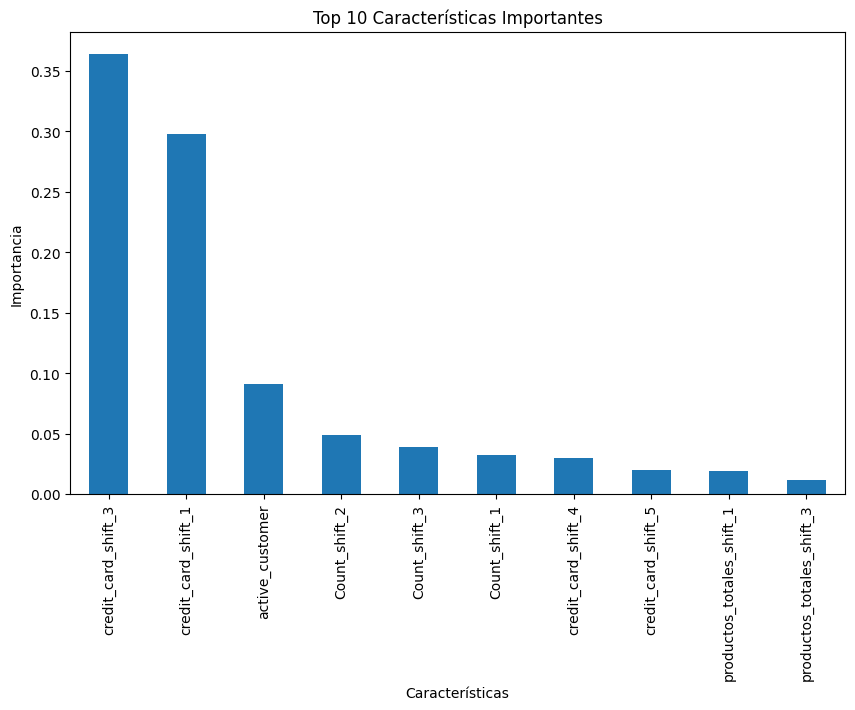

In [62]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title('Top 10 Características Importantes')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()

In [63]:
pred_loans = dt.predict_proba(junio_pred)

In [67]:
np.set_printoptions(suppress=True)


In [68]:
pred_loans

array([[0.        , 0.99966939, 0.00033061],
       [0.        , 0.99687719, 0.00312281],
       [0.        , 0.99085917, 0.00914083],
       ...,
       [0.        , 0.99966939, 0.00033061],
       [0.        , 0.99966939, 0.00033061],
       [0.        , 0.99966939, 0.00033061]])

In [65]:
# Convertir pred_loans a un DataFrame con nombres de columna adecuados
pred_loans_df = pd.DataFrame(pred_loans, index=junio_datos.index, columns=['Probabilidad_Baja', 'Probabilidad_Mantener', 'Probabilidad_Alta'])

# Concatenar junio_datos y pred_loans_df por columnas
junio_pred_con_identif = pd.concat([junio_datos, pred_loans_df], axis=1)

# Ver el DataFrame resultante
print(junio_pred_con_identif)

          pk_cid  Probabilidad_Baja  Probabilidad_Mantener  Probabilidad_Alta
5859968    16203                0.0               0.999669           0.000331
5859969    16502                0.0               0.996877           0.003123
5859970    17457                0.0               0.990859           0.009141
5859971    17799                0.0               0.999669           0.000331
5859972    17970                0.0               0.990859           0.009141
...          ...                ...                    ...                ...
6204667  1553456                0.0               0.999669           0.000331
6204668  1553541                0.0               0.999669           0.000331
6204669  1553559                0.0               0.999669           0.000331
6204670  1553565                0.0               0.999669           0.000331
6204671  1553571                0.0               0.999669           0.000331

[344704 rows x 4 columns]


In [66]:
junio_pred_con_identif.query('Probabilidad_Alta>0.6').shape

(20, 4)